## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

### Data loading: "Евгений Онегин"


In [2]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-12-12 18:31:49--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.1’

onegin.txt.1        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-12 18:31:50 (8.05 MB/s) - ‘onegin.txt.1’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

In [4]:
text

'\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\n\n\n\nii\n\nтак думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меня\n\n\niii\n\nслужив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но 

Put all the characters, that you've seen in the text, into variable `tokens`.

In [5]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [6]:
len(tokens)

83

In [7]:
# dict <index>:<char>
# Your great code here


token_to_index = {
    token : id for id, token in enumerate(tokens)  
}

index = np.arange(len(tokens))
index_to_token = dict(zip(index, tokens))



# dict <char>:<index>
# Your great code here

In [8]:
encoded_text = np.array([token_to_index[ch] for ch in text])

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
class PoemGeneratorRNN(nn.Module):
    def __init__(self, hidden_size, n_layers=1, n_classes=83):
        super(PoemGeneratorRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.ident = torch.eye(n_classes)
        self.rnn = nn.RNN(n_classes, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, n_classes)
    
    def forward(self, inp, hidden_0=None):
        inp = self.ident[inp]
        if hidden_0 is None:
            hidden_0 = torch.zeros(self.n_layers, inp.size(0), self.hidden_size)
        output, hidden_n = self.rnn(inp, hidden_0)
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.decoder(output)
        return output, hidden_n


In [10]:
def get_batches(arr, batch_size, seq_length):

    batch_size_total = batch_size * seq_length

    n_batches = len(arr)//batch_size_total

    arr = arr[:n_batches * batch_size_total]
    arr = arr.reshape((batch_size, -1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:, n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

#took from here https://stackoverflow.com/questions/56201842/how-to-calculate-correct-batch-size-for-lstm

In [11]:
def train_model(model, train_loader, val_loader, loss_fn, opt, epochs=30, batch_size=16, seq_length=50):
    train_loss = []
    validation_loss = []

    for epoch in range(epochs):
        train_loss.append(train_single_epoch(model, train_loader, loss_fn, opt, batch_size, seq_length))
        validation_loss.append(validate_single_epoch(model, val_loader, loss_fn, batch_size, seq_length))

    return train_loss, validation_loss

In [12]:
def train_single_epoch(model, train_loader, loss_fn, opt, batch_size, seq_length):
    loss_sum = 0
    batches = 0
    model.train()
    for x, y in get_batches(train_loader, batch_size, seq_length):
        batches += 1
        
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
        targets = targets.reshape((batch_size * seq_length,))
        model.zero_grad()
        output, h = model(inputs)

        loss = loss_fn(output, targets)
        loss.backward()
        loss_sum += loss
        opt.step()
    return loss_sum / batches

In [13]:
def validate_single_epoch(model, val_loader, loss_fn, batch_size, seq_length):
    loss = 0
    batches = 0
    model.eval()
    for x, y in get_batches(val_loader, batch_size, seq_length):
        batches += 1
        
        inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
        targets = targets.reshape((batch_size * seq_length,))
            
        output, val_h = model(inputs)

        loss += loss_fn(output, targets)                
        
    return loss / batches

In [14]:
model = PoemGeneratorRNN(256)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_set = encoded_text[:len(encoded_text)*8//10]
validation_set = encoded_text[len(encoded_text)*8//10:]
train_loss, validation_loss = train_model(model, train_set, validation_set, loss_fn, optimizer)

In [15]:
def plot_train_process(train_loss, validation_loss):
    plt.figure(figsize=(8, 6))
    plt.title('Loss')
    plt.plot(train_loss, label='train')
    plt.plot(validation_loss, label='validation')
    plt.legend() 

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Vanilla RNN loss


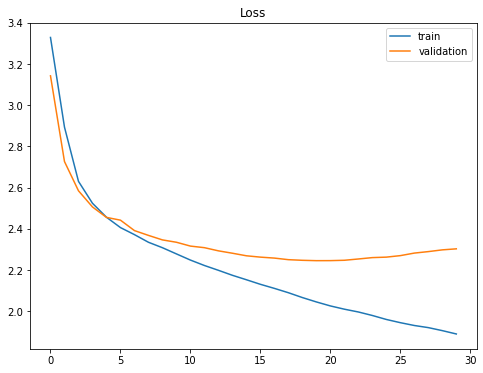

In [16]:
print("Vanilla RNN loss")
plot_train_process(train_loss, validation_loss)

In [17]:
def generate_sample(char_rnn, seed_phrase=' привет', max_length=200, temperature=1.0):
    x_sequence = [token_to_index[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    # hid_state = char_rnn.initial_state(batch_size=1)
    
    char_rnn.eval()
    hid_state = None
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[:, :, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[:, :, -1], hid_state)
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)

        x_sequence = torch.cat([x_sequence, next_ix[None, :, :]], dim=2)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0][0]])

In [18]:
print(generate_sample(model))

 приветрегу нох ростевол непедай
ноконно бытслуе куменит
плидет тифра то прочел улег» я на роста, пруменит, нуждених;
и сказым я не топрожалазь, теннем водыем…
и умыл чед зеревал
с ницей пелвые доше!.


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [19]:
class PoemGeneratorLSTM(nn.Module):
    def __init__(self, hidden_size, n_layers=1, n_classes=83):
        super(PoemGeneratorLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.ident = torch.eye(n_classes)
        self.rnn = nn.LSTM(n_classes, hidden_size, num_layers=self.n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, inp, hidden_0=None):
        inp = self.ident[inp]
        inp = self.activation(inp)
        if hidden_0 is None:
            hidden_0 = (torch.zeros(self.n_layers, inp.size(0), self.hidden_size),
                        torch.zeros(self.n_layers, inp.size(0), self.hidden_size))
        output, hidden_n = self.rnn(inp, hidden_0)
        output = output.contiguous().view(-1, self.hidden_size)
        output = self.activation(output)
        output = self.dropout(output)
        output = self.activation(output)
        output = self.decoder(output)
        return output, hidden_n

In [20]:
model_LSTM = PoemGeneratorLSTM(256)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters())
train_set = encoded_text[:len(encoded_text)*8//10]
validation_set = encoded_text[len(encoded_text)*8//10:]
train_loss, validation_loss = train_model(model_LSTM, train_set, validation_set, loss_fn, optimizer, epochs=20)

LSTM loss


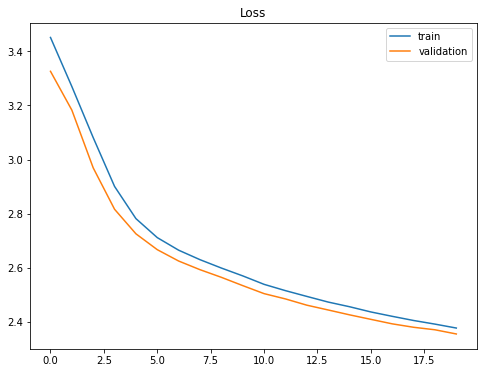

In [21]:
print("LSTM loss")
plot_train_process(train_loss, validation_loss)

The graph looks unambiguously better (the loss on the train and validation decreases equally). I will only compare up to epoch 20, since LSTM was trained for 20 epochs (not enough RAM for 30 epochs). As we can see from the graphs on validation the final loss is about the same, and on train the RNN's loss is lower. 

In [22]:
print(generate_sample(model_LSTM))

 привет,
ногом свепород чожен.
гоподружитей ер гетьял свы,
и удстот озиной своиов,
но оздоти поэта вниг.,
поча тари притой гиль: что, онля вболним врахатье ено-:
и  лада в селавосянь,
на деттыт. ме д 


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [23]:
temperature_params = np.array([0.1, 0.2, 0.5, 1.0, 2.0])
for param in temperature_params:
  print('--------START--------')
  print(f'temperature = {param}:')
  print(generate_sample(model_LSTM))
  print('---------END--------')

--------START--------
temperature = 0.1:
 приветель ойцдягал самодо.



xxxii

вдим биех чаве вворанесюуспере
гообеем волнини вазбыл;
оне комувчей, к эно и затве
сстук былевст я соборатом.
чукы, н метальст роблый она,
поснем всякай бым шини…
---------END--------
--------START--------
temperature = 0.2:
 приветем
го дру зани сораст слеутья,
сочим ть бери пернонно арк
нуромням стедсор семат.



xxii

пещеним, ячказ нассьша!



xii

поркит промяв х су срачита бивыб.
конаю ватяв мортосень!



xvii

еста
---------END--------
--------START--------
temperature = 0.5:
 приветренетбла?
оненоетряш сфразтемни!
и чтоная даждий, деги вглот,
то шеплу. ичтя нед укавка;
не доб оенчем ореенею плоtе,
резлакны мола не нездом силочон,
и на рогея полтет.,
но ястела одоко грею.

---------END--------
--------START--------
temperature = 1.0:
 привет длядь вемь слидет,
и до плотаден, мо слтерки,
а доща, талу длию,
фмуший; су титерсвижел; на биренной
пружала цажоло лавдой вах
татнееных храето побавита.
стравзра

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [24]:
torch.save(model_LSTM, './best_model.pth')
model_loaded = torch.load('./best_model.pth')
print(generate_sample(model_loaded))

 приветменые, масфеенослиж,
тогя на кашеч оне. ны, жусту…нкею пода,
бои и мазберетем несь;
постраламит базсьины тохот,
тирелит навирзалуфо;
морась о  ты тенчарнный, дем,
мокрановы: огониру,
иды мовюхо


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)